# Code to automate preprocessing of openbeacon id.

Requires having a file combining all chip data in long format

1. Calculate eigenvector centrality to find most connected chips
2. walk graph by iteratively estimating a robust regression to calculate timing offset of remote chip until all chips have been aligned to common time.
3. drop outlier datapoints


In [182]:
import os
import glob
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.stats import regress
import networkx as nx

base_dir = '/Users/lukechang/Dropbox/MIND_OpenBeacon/'

# Preprocessing functions

In [252]:
def tag_centrality(data):
    '''Calculate tag eigenvector centrality from the long format data'''
    tag_me_id = data['tag_me'].unique()
    missing_tags = set(data['tag_them']) - set(data['tag_me'])
    tag_adjacency = pd.DataFrame(np.zeros((len(tag_me_id),len(tag_me_id))), index=tag_me_id, columns=tag_me_id)
    tag_duration = {}
    for i,tag_1 in enumerate(tag_me_id):
        tag_1_dat = data.loc[(data['tag_me'] == tag_1) & (data['group'] == 1)]
        tag_duration[tag_1] = tag_1_dat['time_local_s'].max() - tag_1_dat['time_local_s'].min()
        tag_2_id = [x for x in tag_1_dat['tag_them'].unique() if x not in missing_tags]
        for j,tag_2 in enumerate(tag_2_id):
            tag_adjacency.loc[tag_1, tag_2] = 1
    g = nx.from_pandas_adjacency(tag_adjacency)
    return nx.eigenvector_centrality(g)

def find_most_connected_tag(tag_centrality):
    return max(tag_centrality, key=tag_centrality.get)

def find_outliers(residuals, outlier_threshold = 3):
    '''This function identifies any values that are greater than a threshold 
        of the residual standard error of the estimate.
    '''
    return np.abs(residuals) > outlier_threshold*residuals.std()

 

# Load Data

In [349]:
data = pd.read_csv(os.path.join(base_dir, 'Data','mind_openbeacon_long.csv'), index_col=0)
missing_tags = set(data['tag_them']) - set(data['tag_me'])

In [348]:
print(len(data['tag_me'].unique()))
print(len(data['tag_them'].unique()))
data.head()

30
36


,tag_me,tag_them,time_local_s,time_remote_s,rssi,angle,group,rssi_recoded
0,0x4E28C018,0x3E508E4C,620,11455,-82,-18,1,7
1,0x4E28C018,0x3E508E4C,635,11471,-87,0,1,2
2,0x4E28C018,0x3E508E4C,637,11472,-86,1,1,3
3,0x4E28C018,0x3E508E4C,638,11474,-85,2,1,4
4,0x4E28C018,0x3E508E4C,639,11475,-85,-1,1,4


## Run Regression to estimate slope and pairwise temporoal

Notes: 
- Only looking at Group 1 for now.

In [456]:
group = 1
missing_tags = set(data['tag_them']) - set(data['tag_me'])

eig_centrality = tag_centrality(data)
sorted_ids_centrality = [x[0] for x in sorted(eig_centrality.items(), key=lambda kv: kv[1], reverse=True)]

# Initialize first chip w/ highest eigenvector centrality.
aligned_list = [sorted_ids_centrality[0]]
data['time_local_aligned'] = data['time_local_s'].copy()
data['outliers'] = False

temporally_aligned = {}
bad_alignment = {}
alignment = {}
for tag_1 in sorted_ids_centrality:
#     tag_1_dat = data.loc[(data['tag_me'] == tag_1)]
    tag_1_dat = data.loc[(data['tag_me'] == tag_1) & (data['group'] == group)]
    if tag_1 in aligned_list:
        tag_1_dat['time_local_s'] = tag_1_dat['time_local_aligned']        
    
    # Skip tags that are bad or have already been aligned.
    tag_2_id = [x for x in tag_1_dat['tag_them'].unique() if x not in missing_tags]
    tag_2_id = list(set(tag_2_id).difference(set(temporally_aligned)))
    
    tag_2_alignment = {}
    for tag_2 in tag_2_id:
        tag_2_dat = tag_1_dat.loc[data['tag_them'] == tag_2]
        design_matrix = np.vstack([np.ones(len(tag_2_dat['time_local_s'])), tag_2_dat['time_local_s']]).T
        b, t, p, df, res = regress(design_matrix, tag_2_dat['time_remote_s'], mode='robust')
        tag_2_alignment[tag_2] = {'remote_offset':b[0], 'remote_drift':b[1]}
        if np.isclose(b[1], 1):
#             data['time_local_aligned'].loc[(data['tag_me'] == tag_2)] = np.round(data['time_local_aligned'].loc[(data['tag_me'] == tag_2)] - b[0]).astype(int)
            data['time_local_aligned'].loc[(data['tag_me'] == tag_2) & (data['group'] == group)] = np.round(data['time_local_aligned'].loc[(data['tag_me'] == tag_2) & (data['group'] == group)] - b[0]).astype(int)
            aligned_list.append(tag_2)
#             data['outliers'].loc[(data['tag_me'] == tag_1) & (data['tag_them'] == tag_2)] = find_outliers(res)
            data['outliers'].loc[(data['tag_me'] == tag_1) & (data['tag_them'] == tag_2) & (data['group'] == group)] = find_outliers(res)
            temporally_aligned[tag_1] = tag_2
        else:
            bad_alignment[tag_1] = tag_2
    alignment[tag_1] = tag_2_alignment


/Users/lukechang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/lukechang/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/lukechang/anaconda3/lib/python3.7/site-packages/nltools-0.3.14-py3.7.egg/nltools/stats.py:997: RuntimeWarning: divide by zero encountered in true_divide
  t = b / stderr


## Drop bad data

In [457]:
cleaned_data = data.copy()

# Drop poorly aligned participants & different types of outliers
cleaned_data = cleaned_data.loc[~cleaned_data['tag_me'].isin(list(set(bad_alignment.values())))]
cleaned_data = cleaned_data.loc[~cleaned_data['outliers']]
cleaned_data = cleaned_data.loc[~(cleaned_data['time_local_aligned'].abs() > cleaned_data['time_local_aligned'].std()*3)]

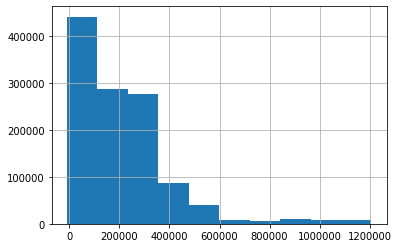

In [406]:
cleaned_data['time_local_aligned'].hist()

## Create Graph over time

In [461]:
n_epochs = 20
group = 1
epochs = np.linspace(cleaned_data['time_local_aligned'].min(), cleaned_data['time_local_aligned'].max(), n_epochs)

all_epoch_data = {}
start = epochs[0]
for i,t in enumerate(epochs[1:2]):
    epoch_data = cleaned_data.loc[(cleaned_data['time_local_aligned'] >= start) & (cleaned_data['time_local_aligned'] < stop) & cleaned_data['group'] == group]
    all_dat = pd.DataFrame()
    for s in epoch_data['tag_me'].unique():
        sub_dat = epoch_data.loc[epoch_data['tag_me'] == s]
        sub_dat = sub_dat.groupby(sub_dat['tag_them']).mean()
        sub_dat['tag_me'] = s
        sub_dat['tag_them'] = sub_dat.index
        all_dat = all_dat.append(sub_dat)
    all_epoch_data[i] = all_dat
    start = stop
    stop = t

In [462]:
all_epoch_data[0]

,time_local_s,time_remote_s,rssi,angle,group,rssi_recoded,time_local_aligned,outliers,tag_me,tag_them
tag_them,,,,,,,,,,
0x04958E5A,51542.307042,50373.864789,-81.226479,12.701972,1.000000,7.773521,51542.307042,False,0x4971A32A,0x04958E5A
0x08007C57,216660.345878,128449.684588,-79.259857,8.411290,1.098566,9.740143,216660.345878,False,0x4971A32A,0x08007C57
0x0B3054C1,112731.408913,112682.310248,-80.234869,8.091238,1.008030,8.765131,112731.408913,False,0x4971A32A,0x0B3054C1
0x0D0BE65C,85476.455439,123929.801404,-83.896842,7.839298,1.047719,5.103158,85476.455439,False,0x4971A32A,0x0D0BE65C
0x122E9CEA,37847.637931,36400.917625,-84.055556,12.940613,1.153257,4.944444,37847.637931,False,0x4971A32A,0x122E9CEA
0x126EBE99,113040.116796,83530.732481,-81.958287,3.481646,1.050056,7.041713,113040.116796,False,0x4971A32A,0x126EBE99
0x138A8579,22344.629213,15191.808989,-73.348315,2.966292,2.528090,15.651685,22344.629213,False,0x4971A32A,0x138A8579
0x178B804D,123573.870423,165793.115493,-81.473239,-4.346479,1.245070,7.526761,123573.870423,False,0x4971A32A,0x178B804D
0x1ED0E4C2,41780.402093,38085.689836,-82.609118,14.793722,1.077728,6.390882,41780.402093,False,0x4971A32A,0x1ED0E4C2


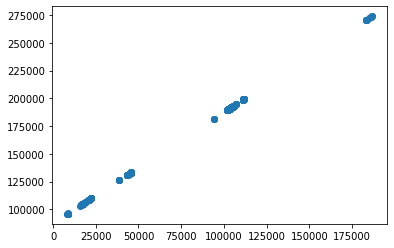

In [407]:
plt.scatter(tag_2_dat['time_local_s'], tag_2_dat['time_remote_s'])

In [200]:
tag_me_id = data['tag_me'].unique()
missing_tags = set(data['tag_them']) - set(data['tag_me'])

tag_intercept = np.ones((len(tag_me_id),len(tag_me_id)))*np.nan
tag_slope = tag_intercept.copy()

for i, tag_1 in enumerate(tag_me_id):
    tag_1_dat = data.loc[(data['tag_me'] == tag_1) & (data['group'] == 1)]
    tag_2_id = [x for x in tag_1_dat['tag_them'].unique() if x not in missing_tags]
    for j, tag_2 in enumerate(tag_2_id):
        tag_2_dat = tag_1_dat.loc[data['tag_them'] == tag_2]
        dm = np.vstack([np.ones(len(tag_2_dat['time_local_s'])), tag_2_dat['time_local_s']]).T
        b, t, p, df, res = regress(dm, tag_2_dat['time_remote_s'], mode='robust')
        tag_intercept[i,j], tag_slope[i,j] = b
        

In [381]:
data.head()

,tag_me,tag_them,time_local_s,time_remote_s,rssi,angle,group,rssi_recoded,time_local_aligned,outliers
0,0x4E28C018,0x3E508E4C,620,11455,-82,-18,1,7,4511141,False
1,0x4E28C018,0x3E508E4C,635,11471,-87,0,1,2,4511156,False
2,0x4E28C018,0x3E508E4C,637,11472,-86,1,1,3,4511158,False
3,0x4E28C018,0x3E508E4C,638,11474,-85,2,1,4,4511159,False
4,0x4E28C018,0x3E508E4C,639,11475,-85,-1,1,4,4511160,False


[8.74596089e+04 1.00000827e+00]


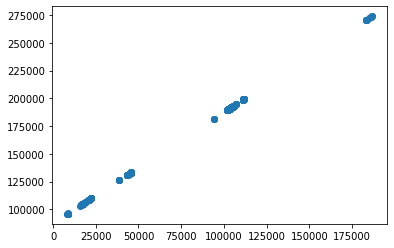

In [382]:
tag_1 = tag_me_id[0]
tag_1_dat = data.loc[(data['tag_me'] == tag_1)]
tag_2_id = [x for x in tag_1_dat['tag_them'].unique() if x not in missing_tags]
tag_2 = tag_me_id[1]
tag_2_dat = tag_1_dat.loc[data['tag_them'] == tag_2]
tag_2_dat['group'].unique()
design_matrix = np.vstack([np.ones(len(tag_2_dat['time_local_s'])), tag_2_dat['time_local_s']]).T
b, t, p, df, res = regress(design_matrix, tag_2_dat['time_remote_s'], mode='robust')
plt.scatter(tag_2_dat['time_local_s'], tag_2_dat['time_remote_s'])
print(b)

In [434]:
data['group'].groupby(data['group']).count()

group
1     1261647
2      107060
3       62789
4       13078
5       10099
6        8633
7        4225
8        7896
9        1537
10        411
11        365
Name: group, dtype: int64

1175011

In [389]:
list(set(bad_alignment.values()))

['0x2FC03DD0', '0x71F89276', '0x4803050D', '0x392C8E4F', '0x5716C298']

In [362]:
sorted_ids_centrality

['0x126EBE99',
 '0x4971A32A',
 '0x784692B5',
 '0x08007C57',
 '0x5716C298',
 '0x4094EFF9',
 '0x3E508E4C',
 '0x0D0BE65C',
 '0x04958E5A',
 '0x50126E5B',
 '0x57017A64',
 '0x4266810A',
 '0x4095A5C2',
 '0x34AB57A6',
 '0x66092520',
 '0x71F89276',
 '0x1ED0E4C2',
 '0x6EDA7A0D',
 '0x33B9F6B6',
 '0x4803050D',
 '0x392C8E4F',
 '0x6E0E454C',
 '0x122E9CEA',
 '0x779E9C74',
 '0x5D82E411',
 '0x178B804D',
 '0x2FC03DD0',
 '0x4E28C018',
 '0x138A8579',
 '0x57BE2613']

In [378]:
len(aligned_list)

82

In [384]:
data.loc[data['outliers']].shape

(1058, 10)

In [379]:
g = nx.from_numpy_array()
pos = pos = nx.spring_layout(g) # Another way of specifiying a layout for nodes.
nx.draw(g,with_labels=False,node_size=200,font_size=20,alpha=.9,width=2,node_color='skyblue',edge_color='navy',edgecolors='navy')


TypeError: from_numpy_array() missing 1 required positional argument: 'A'

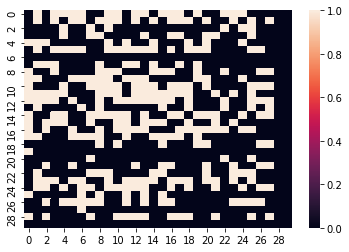

In [213]:
sns.heatmap(np.isclose(tag_slope, 1))

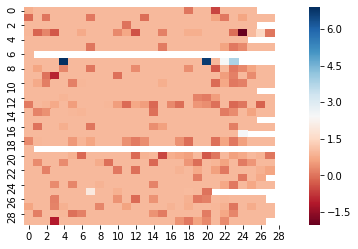

In [156]:
sns.heatmap(tag_slope, cmap='RdBu')

(array([159.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([0.00621119, 0.05846067, 0.11071015, 0.16295963, 0.21520911,
        0.26745859, 0.31970807, 0.37195755, 0.42420703, 0.47645651,
        0.52870599]),
 <a list of 10 Patch objects>)

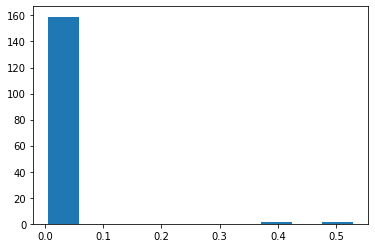

In [161]:
plt.hist(np.diagonal(dm.dot(np.linalg.pinv(dm))))

# Calculate eigenvector centrality of each tag to identify regression order

'0x126EBE99'

(array([ 7.,  1.,  1.,  1.,  0.,  0.,  3.,  0., 15.,  2.]),
 array([  2633. ,  34379.2,  66125.4,  97871.6, 129617.8, 161364. ,
        193110.2, 224856.4, 256602.6, 288348.8, 320095. ]),
 <a list of 10 Patch objects>)

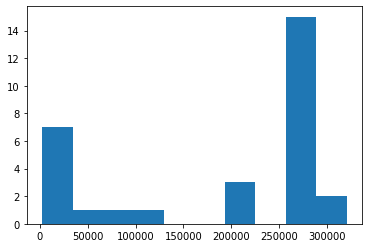

In [196]:
plt.hist(tag_duration.values())

In [166]:
tag_1_dat['time_local_s'].max() - tag_1_dat['time_local_s'].min()

280673

In [186]:
g?

In [183]:
nx.from_pandas_dataframe(tag_adjacency)

AttributeError: module 'networkx' has no attribute 'from_pandas_dataframe'

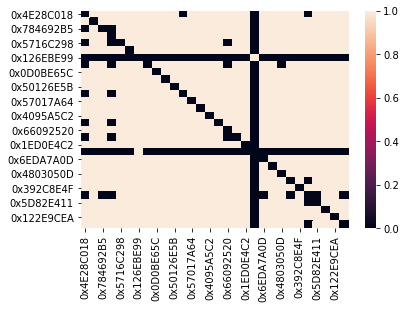

In [180]:
sns.heatmap(tag_adjacency)


/Users/lukechang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  after removing the cwd from sys.path.


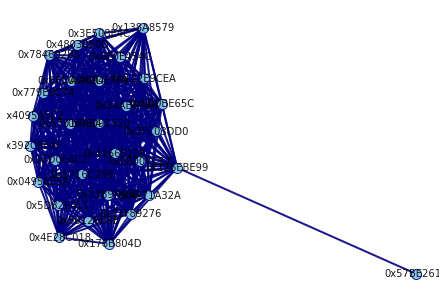

In [359]:
pos = pos = nx.fruchterman_reingold_layout(g) # Another way of specifiying a layout for nodes.
pos = pos = nx.spring_layout(g) # Another way of specifiying a layout for nodes.
nx.draw(g,with_labels=True,node_size=100,font_size=10,alpha=.9,width=2,node_color='skyblue',edge_color='navy',edgecolors='navy')
plt.tight_layout()